# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [20]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
DEVICE = 'cuda:0'
NDIM = 4 # number of parameters
NBINS = 1000

In [22]:
SIGMA = 0.05
def model(z):
    x = sum((z-0.5)**2)**0.5  # Return radial distance from center
    return np.array([x])

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [23]:
z0 = np.array([0.2, 0.5,0.6,0.4])
x0 = noisemodel(model(z0))
x0

array([0.34307613])

In [24]:
ds = swyft.DataStoreZarr("/home/aecole/swyft/notebooks/SP.zarr")
ds.init(zdim = NDIM, xdim = (1,))

Loading datastore: /home/aecole/swyft/notebooks/SP.zarr


In [25]:
sw_list = []

for i_round in range(1):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = NDIM, device = DEVICE, head = None, datastore = ds, nsamples = 15000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
No new simulator runs required.
Start training
LR iteration 0
Total epochs: 14
Validation losses: [10.606884181499481, 10.572087228298187, 10.597831040620804, 10.58145296573639, 10.555769920349121, 10.61957973241806, 10.550466179847717, 10.56708550453186, 10.546576172113419, 10.574389725923538, 10.54371640086174, 10.639293760061264, 10.572868168354034, 10.559522449970245]
LR iteration 1
Total epochs: 6
Validation losses: [10.535888850688934, 10.497617781162262, 10.493945121765137, 10.519895523786545, 10.510304301977158, 10.516878753900528]
LR iteration 2
Total epochs: 8
Validation losses: [10.548975259065628, 10.508455693721771, 10.52938860654831, 10.517463654279709, 10.481625616550446, 10.536633372306824, 10.511949270963669, 10.512898087501526]


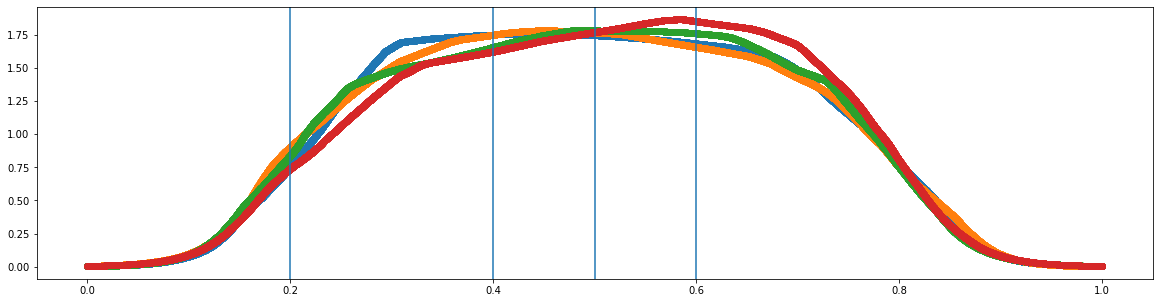

In [7]:
plt.figure(figsize=(20, 5))
for i in range(4):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [26]:
sw_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Start training
LR iteration 0
Total epochs: 5
Validation losses: [2.546052113175392, 2.442452698945999, 2.5074782371520996, 2.4624892063438892, 2.445030093193054]
LR iteration 1
Total epochs: 12
Validation losses: [2.450135350227356, 2.4469620771706104, 2.4469881393015385, 2.42770878598094, 2.4445643089711666, 2.445232480764389, 2.4078667499125004, 2.3979165703058243, 2.388630673289299, 2.4193339720368385, 2.4102284908294678, 2.4285228177905083]
LR iteration 2
Total epochs: 11
Validation losses: [2.414044301956892, 2.4200897812843323, 2.431057136505842, 2.4009483344852924, 2.3989362195134163, 2.414938822388649, 2.4226332381367683, 2.3891797438263893, 2.4301555268466473, 2.416233878582716, 2.42945471778512]


In [9]:
ds.__len__()

14902

In [27]:
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['legend.edgecolor'] = '0.0'
plt.rcParams['figure.figsize'] = 5,5
plt.rcParams.update({'figure.autolayout': True})
#plt.rc('text', usetex=True)
plt.rc('text', usetex=False)
green1='#238E68'
green2='#32CC99' 
green3='#76EEC6'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'

In [28]:
#import torch
#import matplotlib.pyplot as plt
from swyft import posteriors

'''def posteriors(x0, net, dataset, combinations = None, device = 'cpu'):
    x0 = x0.to(device)
    z = torch.stack(swyft.get_z(dataset)).to(device)
    z = torch.stack([swyft.combine_z(zs, combinations) for zs in z])
    lnL = swyft.get_lnL(net, x0, z)
    return z.cpu(), lnL.cpu()'''

# Grid over which to evaluate 2D posterior
n_unique = 100#150
#z_unique = torch.stack(
z_unique = [{"z": z} for z in torch.stack(
    torch.meshgrid([
        torch.linspace(0., 1., n_unique),
        torch.linspace(0., 1., n_unique),
    ])
).flatten(1).t()]
def get_lnLs(net, x, z_unique):
    """
    Gets lnL evaluated over the specified unique z values
    """
    z_grid, lnL_grid = posteriors(
        x.to(DEVICE), net, z_unique, combinations=[[0, 1]], device=DEVICE
    )
    z_grid = z_grid.squeeze()  # <--- map z to physical parameters here
    lnL_grid = lnL_grid.squeeze()
    return (
        z_grid[:, 0].reshape([n_unique, n_unique]),
        z_grid[:, 1].reshape([n_unique, n_unique]),
        lnL_grid.reshape([n_unique, n_unique])
    )
def plot_pos_contour(net, x, ax, z_unique, p_vals=[0.68, 0.95, 0.997]):
    """
    Computes swyft contours for a set of noise realizations.
    """
    # Get posterior over grid
    x_grid, y_grid, lnL_grid = get_lnLs(net, x, z_unique)
    x_grid = x_grid.reshape([n_unique, n_unique])
    y_grid = y_grid.reshape([n_unique, n_unique])
    L_grid = lnL_grid.reshape([n_unique, n_unique]).exp()
    # Compute containment regions
    # Parameter space area around each point in (x_grid, y_grid)
    sq_area = (
        (x_grid[1, 0] - x_grid[0, 0]) * (y_grid[0, 1] - y_grid[0, 0])
    )
    # Compute posterior mass fraction in that region
    frac_mass = L_grid * sq_area
    frac_mass /= frac_mass.sum()
    # For each value of L, compute fraction of posterior mass around points with
    # higher L
    sorted_Ls = torch.sort(L_grid.flatten()).values    
    containment = torch.zeros(L_grid.numel())
    for i, L in enumerate(sorted_Ls):
        containment[i] = frac_mass[L_grid >= L].sum()
    # Figure out mapping from p values to L values
    levels = [0] + [
        sorted_Ls[torch.where(containment < p)[0][0]].item() for p in np.sort(p_vals)[::-1]
    ]
    cs = ax.contour(
        x_grid, y_grid, L_grid, levels=levels, colors=p_val_colors,
        #x_grid, y_grid, L_grid, levels=levels,
        #labels=np.sort(p_vals)[::-1]
        #labels=['68%','95%','99.7%']
    )
    return cs
# Usage example: sw has a netNd_store with a trained network and x is the
# observation to analyze
#plt.figure()
#plot_pos_contour(sw.netNd_store[-1], x, plt.gca(), z_unique)

In [29]:
p_val_colors=['green','red','blue']

Text(0.5, 1.0, 'Shell posterior, swyft (14902 samples)')

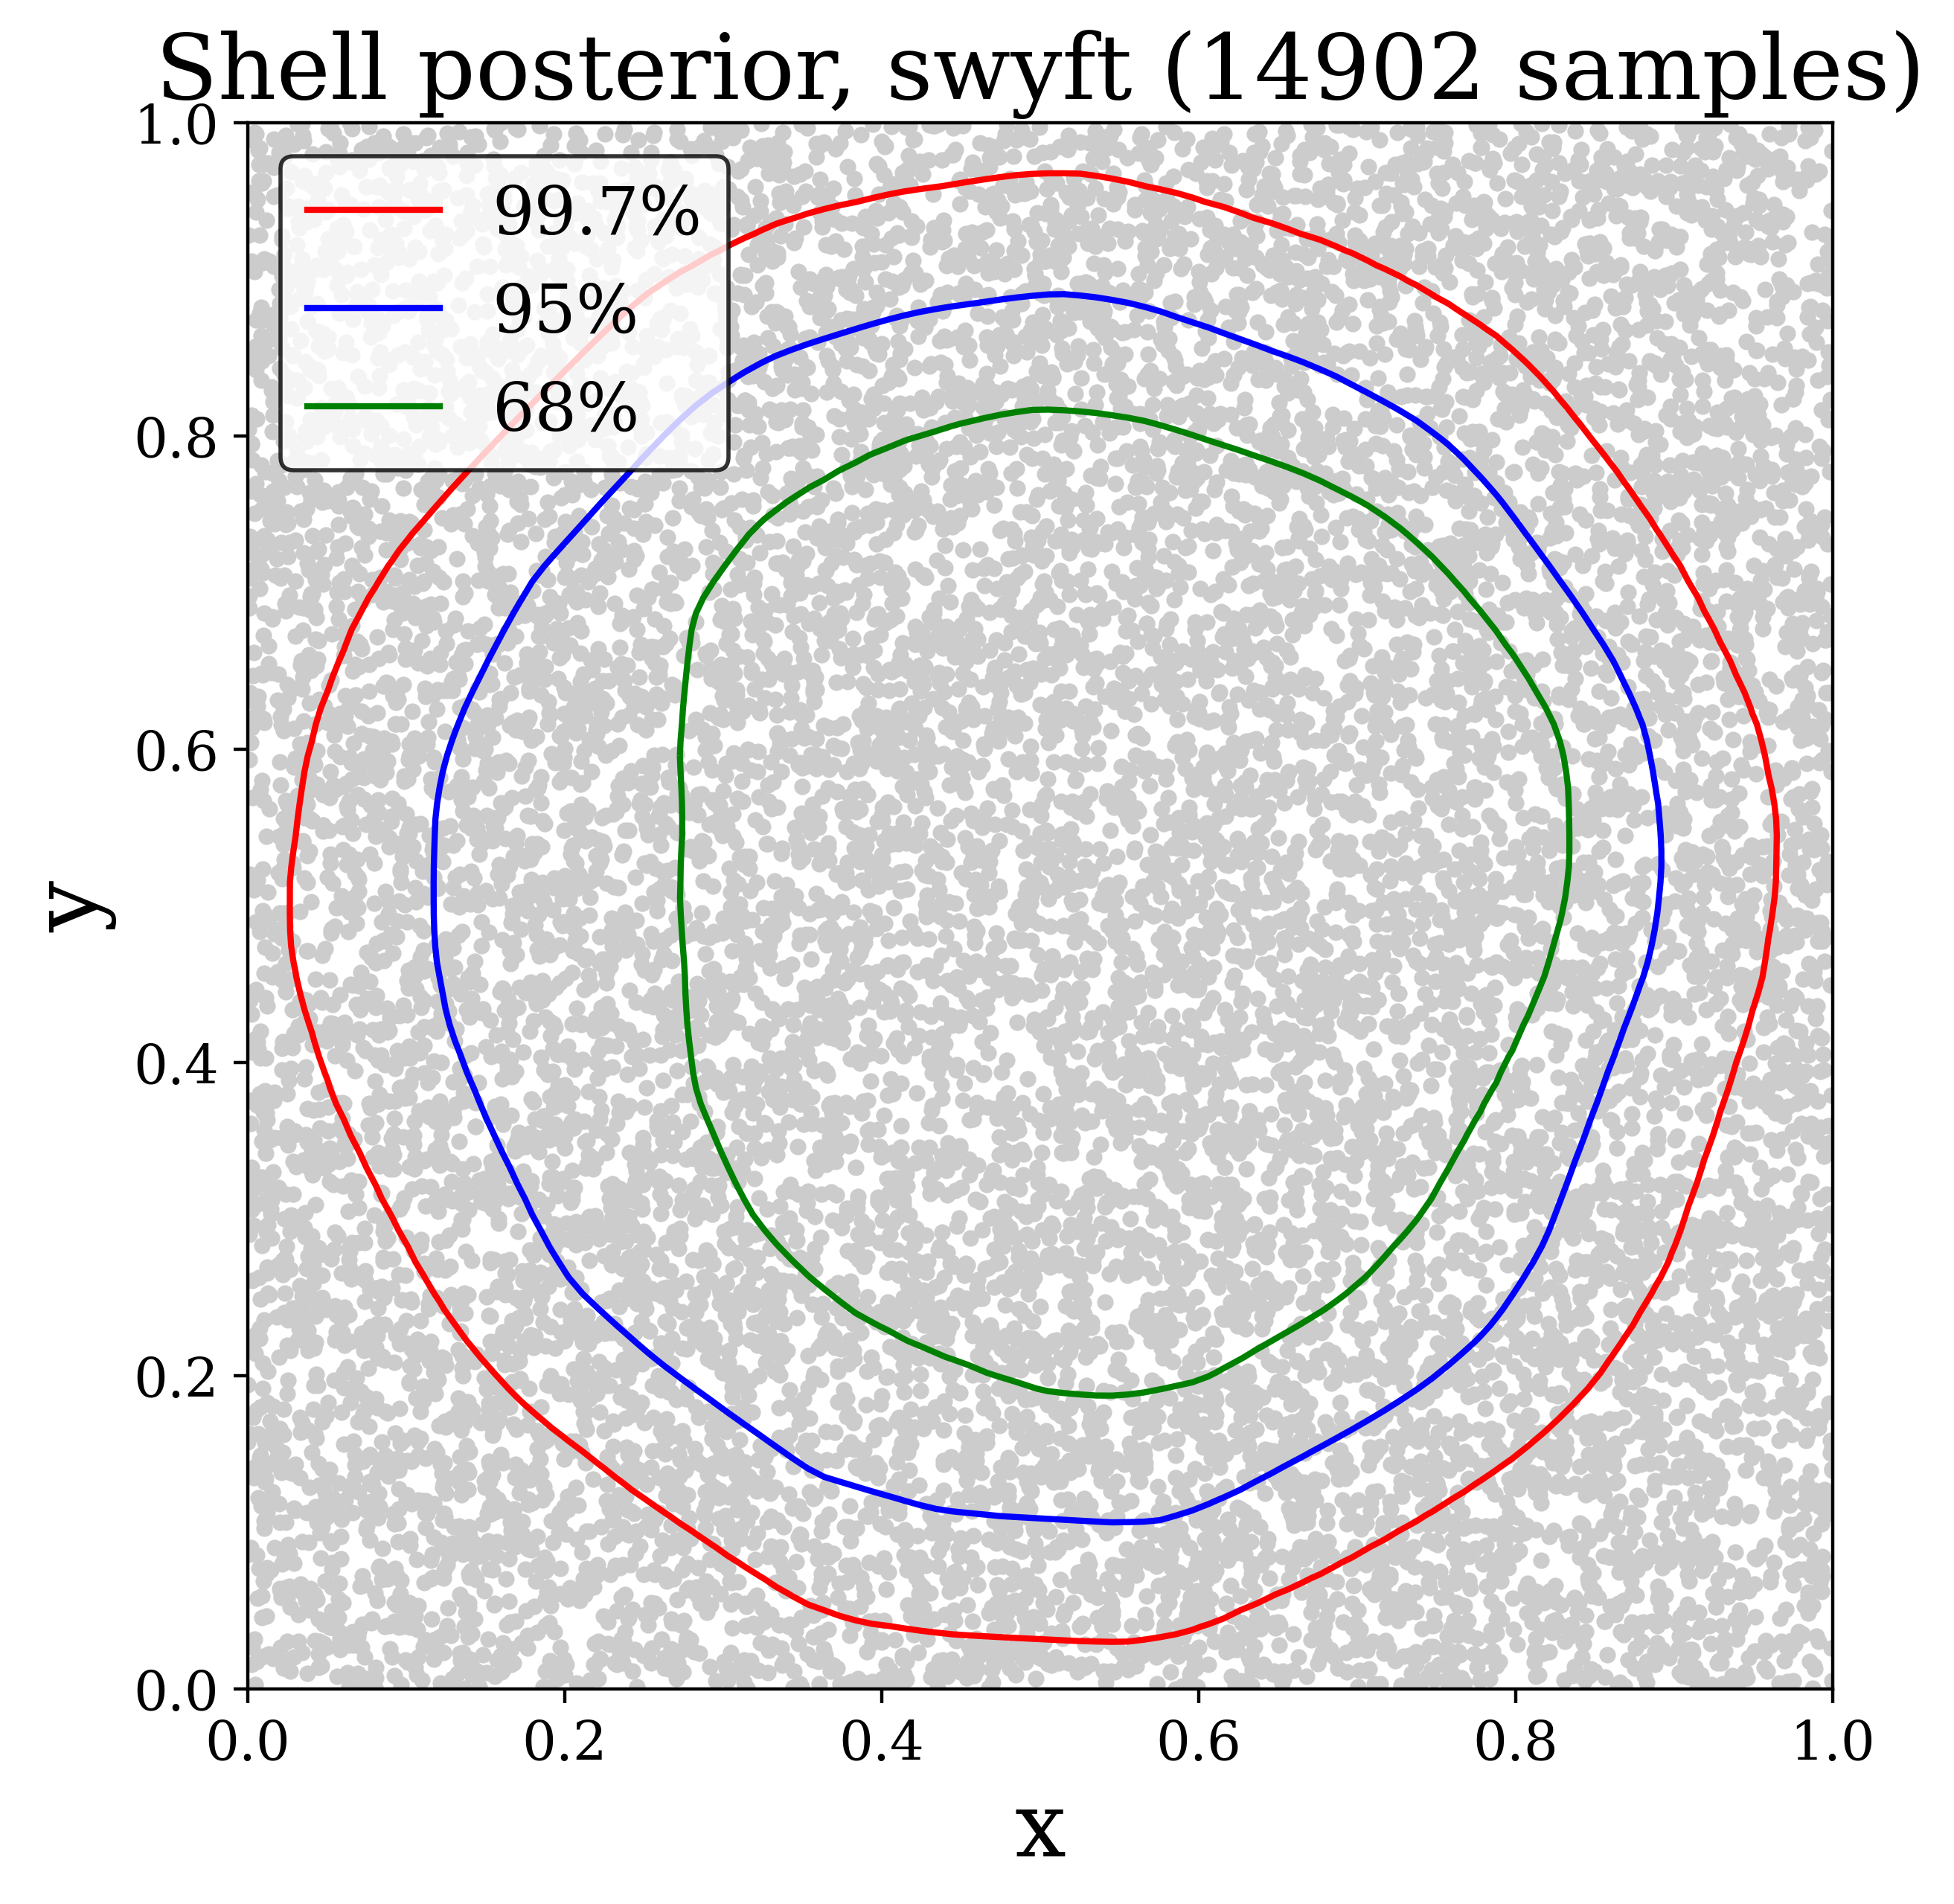

In [40]:
plt.figure(figsize=[6.5,6.5])
zgrid, lnLgrid = sw_list[-1].posterior([0, 1])
#fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
cs=plot_pos_contour(sw.netNd["default"]['net'], torch.tensor(x0).float(), plt.gca(), z_unique)
plt.xlabel('x',fontsize=22)
plt.ylabel('y',fontsize=22)
plt.xlim([0.0,1.0])
plt.ylim([-0.0, 1.0])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#cs.levels = [nf(val) for val in cs.levels]
# Label levels with specially formatted floats
#if plt.rcParams["text.usetex"]:
#    fmt = r'%r \%%'
#else:
#    fmt = '%r %%'
#ax.clabel(cs, inline=True, fontsize=16,labels=["68","95","99.7"]);
plt.plot([3,4],[5,6],color='red',label="99.7%")
plt.plot([3,4],[5,6],color='blue',label="95%")
plt.plot([3,4],[5,6],color='green',label="68%");
plt.legend(fontsize=16,loc='upper left')
plt.title('Shell posterior, swyft (14902 samples)',fontsize=22)

#plt.savefig('Figs/ShellPos2d1.png')

In [153]:
np.random.seed(26)
torch.manual_seed(26)
#z1 = np.array([0.2, 0.5])
#x1 = noisemodel(model(z1))

In [33]:
sw2_list = []

for i_round in range(1):
    parent = None if len(sw2_list) == 0 else sw2_list[-1]
    sw2 = swyft.SWYFT(x0, zdim = NDIM, device = DEVICE, head = None, datastore = ds, nsamples = 20000, noisemodel = noisemodel, parent = parent)
    sw2_list.append(sw2)
    
    if sw2.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw2.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
Adding 5090 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 12
Validation losses: [10.644475817680359, 10.641031384468079, 10.562033474445343, 10.559462189674377, 10.59140956401825, 10.554050624370575, 10.536864519119263, 10.538734018802643, 10.529913544654846, 10.562766432762146, 10.534590542316437, 10.537234485149384]
LR iteration 1
Total epochs: 6
Validation losses: [10.488177329301834, 10.492111474275589, 10.468760311603546, 10.525145828723907, 10.521375864744186, 10.491967856884003]
LR iteration 2
Total epochs: 7
Validation losses: [10.501508593559265, 10.544473767280579, 10.537556201219559, 10.478586822748184, 10.486764937639236, 10.512451887130737, 10.483844250440598]


In [ ]:
ds.__len__()

In [36]:
sw2_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Start training
LR iteration 0
Total epochs: 6
Validation losses: [2.4530840888619423, 2.4680347964167595, 2.432058706879616, 2.4373090267181396, 2.4674815386533737, 2.4356220327317715]
LR iteration 1
Total epochs: 6
Validation losses: [2.3955180943012238, 2.369090110063553, 2.3611855544149876, 2.416704673320055, 2.422034367918968, 2.479222357273102]
LR iteration 2
Total epochs: 6
Validation losses: [2.4194365553557873, 2.399664968252182, 2.3713836781680584, 2.383764423429966, 2.417518261820078, 2.42559627443552]


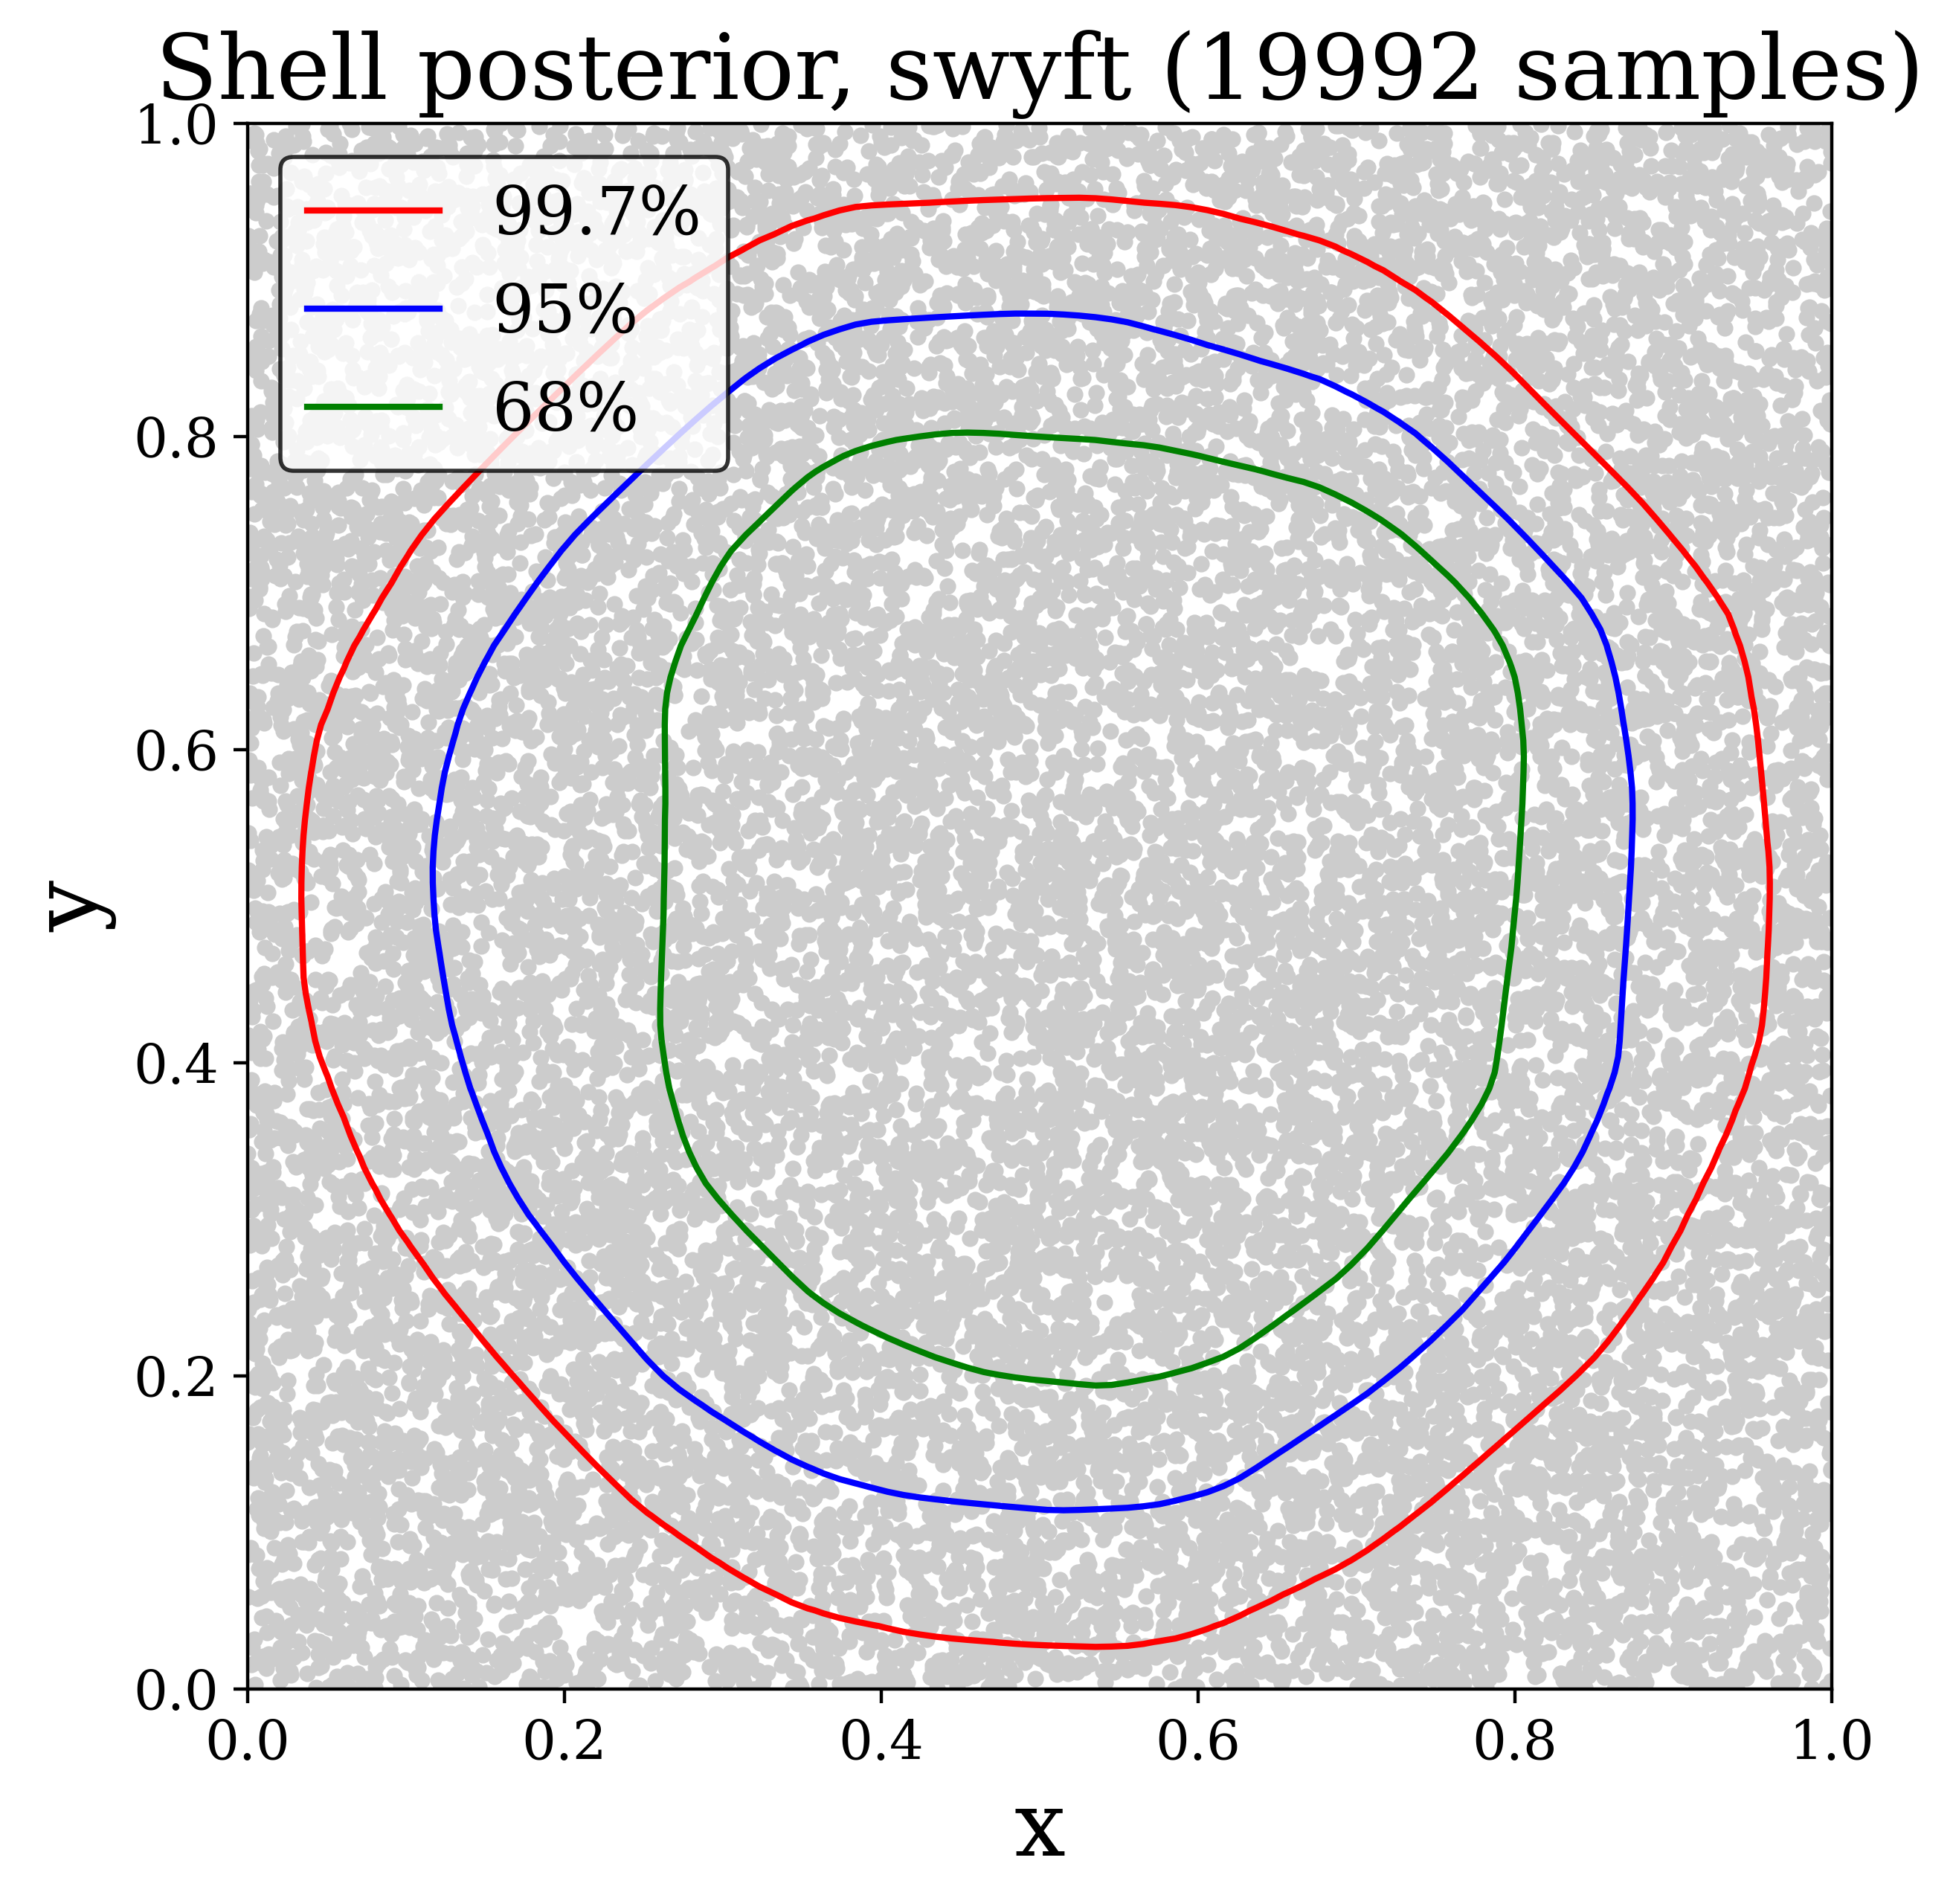

In [41]:
plt.figure(figsize=[6.5,6.5])
zgrid, lnLgrid = sw2_list[-1].posterior([0, 1])
#fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
cs=plot_pos_contour(sw2.netNd["default"]['net'], torch.tensor(x0).float(), plt.gca(), z_unique)
plt.xlabel('x',fontsize=22)
plt.ylabel('y',fontsize=22)
plt.xlim([0.0,1.0])
plt.ylim([-0.0, 1.0])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#cs.levels = [nf(val) for val in cs.levels]
# Label levels with specially formatted floats
#if plt.rcParams["text.usetex"]:
#    fmt = r'%r \%%'
#else:
#    fmt = '%r %%'
#ax.clabel(cs, inline=True, fontsize=16,labels=["68","95","99.7"]);
plt.plot([3,4],[5,6],color='red',label="99.7%")
plt.plot([3,4],[5,6],color='blue',label="95%")
plt.plot([3,4],[5,6],color='green',label="68%");
plt.legend(fontsize=16,loc='upper left')
plt.title('Shell posterior, swyft (19992 samples)',fontsize=22)

plt.savefig('Figs/ShellPos2d2.png')

In [157]:
torch.save(sw_list[-1].posterior([0,1]),'RingPost2d1.pt')
torch.save(sw2_list[-1].posterior([0,1]),'RingPost2d2.pt')

In [158]:
np.random.seed(26)
torch.manual_seed(26)
z2 = np.array([0.2, 0.5])
x2 = noisemodel(model(z2))

sw3_list = []

for i_round in range(1):
    parent = None if len(sw3_list) == 0 else sw3_list[-1]
    sw3 = swyft.SWYFT(x2, zdim = 2, device = DEVICE, head = None, datastore = ds, nsamples = 2500, noisemodel = noisemodel, parent = parent)
    sw3_list.append(sw3)
    
    if sw3.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw3.train1d(max_epochs = 100, nbatch = 16)

sw3_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
No new simulator runs required.
Start training
LR iteration 0
Total epochs: 12
Validation losses: [5.0409481674432755, 4.918505504727364, 4.900732159614563, 4.874326854944229, 4.855847731232643, 4.885854512453079, 4.874719426035881, 4.841727614402771, 4.786769866943359, 4.820750877261162, 4.888495072722435, 4.836286842823029]
LR iteration 1
Total epochs: 5
Validation losses: [4.801274478435516, 4.751002162694931, 4.75443372130394, 4.803417161107063, 4.763007149100304]
LR iteration 2
Total epochs: 7
Validation losses: [4.7369227930903435, 4.805928714573383, 4.725222714245319, 4.714075714349747, 4.7932901084423065, 4.778436414897442, 4.738233536481857]
Start training
LR iteration 0
Total epochs: 8
Validation losses: [2.0816328413784504, 1.8296275325119495, 1.8103506099432707, 1.7480413392186165, 1.7301009837538004, 1.7324400544166565, 1.7436449639499187, 1.74279217235744]
LR iteration 1
Total epochs: 7
Validation losses: [1.670527197420597, 1.6144489943981

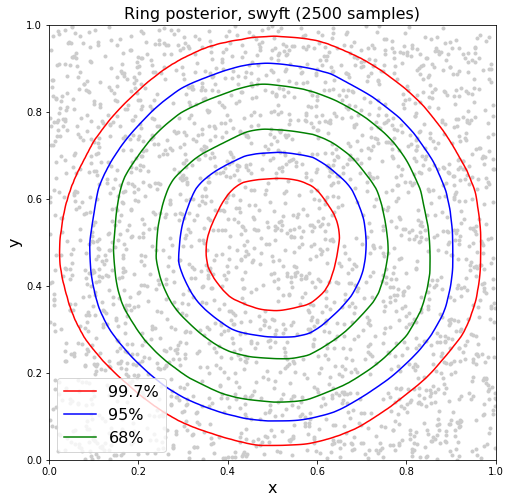

In [168]:
zgrid, lnLgrid = sw3_list[-1].posterior([0, 1])
fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
cs=plot_pos_contour(sw.netNd["default"]['net'], torch.tensor(x0).float(), plt.gca(), z_unique)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.xlim([0.0,1.0])
plt.ylim([-0.0, 1.0])
#cs.levels = [nf(val) for val in cs.levels]
# Label levels with specially formatted floats
#if plt.rcParams["text.usetex"]:
#    fmt = r'%r \%%'
#else:
#    fmt = '%r %%'
#ax.clabel(cs, inline=True, fontsize=16,labels=["68","95","99.7"]);
plt.plot([3,4],[5,6],color='red',label="99.7%")
plt.plot([3,4],[5,6],color='blue',label="95%")
plt.plot([3,4],[5,6],color='green',label="68%");
plt.legend(fontsize=16, loc='lower left')
plt.title('Ring posterior, swyft (2500 samples)',fontsize=16)

plt.savefig('Figs/RingPos2d3.png',dpi=300)